In [94]:
pip install pandas


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data clean from EDA

In [148]:
import pandas as pd

clean_data = pd.read_csv("carinfo_after_pre_clean.csv")
df = pd.DataFrame(clean_data)

df_cleaned_1 = df.dropna(subset = ['exterior_color', 'interior_color', 'fuel'])
df_cleaned = df_cleaned_1[df_cleaned_1['price'] != 0]
df_unique = df_cleaned.drop_duplicates(subset = 'VIN', keep = False)
df_unique = df_unique.drop(columns = ['Unnamed: 0'])
df_unique.columns

Index(['year', 'make', 'model', 'price', 'mileage', 'Miles per gallon',
       'Transmission', 'owner', 'VIN', 'class', 'Auction Brand / Issues',
       'Accident / Damage', 'Open Recall Check', 'Odometer Check',
       'Certified Pre-Owned', 'cylinders', 'fuel', 'Drive type',
       'Miles per gallon equivalent (MPGe)', 'Range (when new)',
       'Time to fully charge battery (240V)', 'Motor', 'Bed Length',
       'exterior_color', 'interior_color'],
      dtype='object')

In [11]:
pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Q1 Does color matter for used car prices and how does it affect them?
## Hypothesis 1
The exterior colors of most used cars are relatively concentrated, and the prices of used cars will not fluctuate too much due to color.  
Answer:
In terms of exterior colors, black, white, and gray are the most common, while in terms of interior colors, black is the most common. This pattern reflects people's preference for car colors but color is not the important factor for the prices of used cars.

## Hypothesis 2
The interior colors of high-end vehicles are generally red, so the price of used cars with these colors will be relatively higher.  
Answer:  
While color is not the primary factor in determining car price, a red interior can still be an influential aspect, particularly for high-end vehicles where it often adds to the overall appeal and value.

### Process 1. Use SelectKBest to find top important features

In [150]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

# Encoding by one-hot and split the data into training and testing sets
df_encoded = pd.get_dummies(df_unique)
if 'fuel_encoded' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns = ['fuel_encoded'])
train_data, test_data = train_test_split(df_encoded, test_size = 0.2, random_state = 42)
x_train = train_data.drop(columns = ['price'])
y_train = train_data['price']

# Impute NaN values in x_train
imputer = SimpleImputer(strategy = "mean")
x_train_imputed = imputer.fit_transform(x_train)

# Use SelectKBest to find the top k important features
selector = SelectKBest(score_func = f_regression, k = min(20, x_train_imputed.shape[1]))
X_new = selector.fit_transform(x_train_imputed, y_train)

# Selected feature names
selected_features = selector.get_support(indices = True)
selected_feature_names = x_train.columns[selected_features]

# Extract the base feature names
base_feature_names = list(set([name.split('_')[0] for name in selected_feature_names]))
print("Top 11 important base feature names:", base_feature_names)

selected_feature_names_by_KB = selected_feature_names

Top 11 important base feature names: ['fuel', 'mileage', 'Drive type', 'make', 'year', 'interior', 'Miles per gallon', 'Bed Length', 'owner', 'class', 'cylinders']


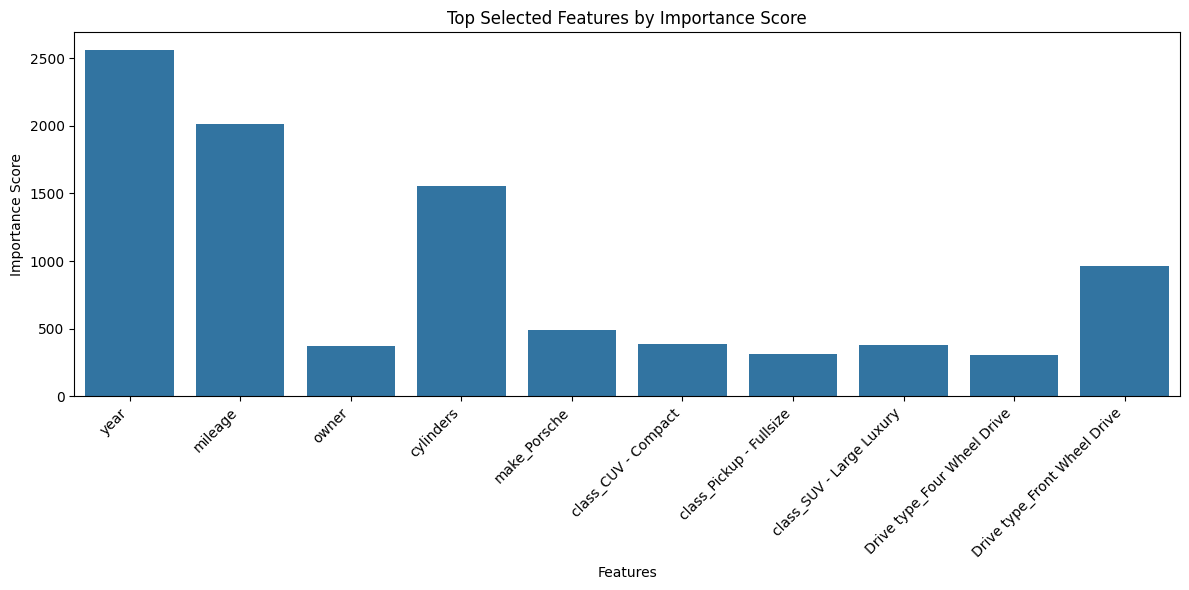

/var/folders/gw/f0bp5qm956zdx_zp29qydky00000gn/T/ipykernel_9325/4194511449.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['price'] = y_train.values


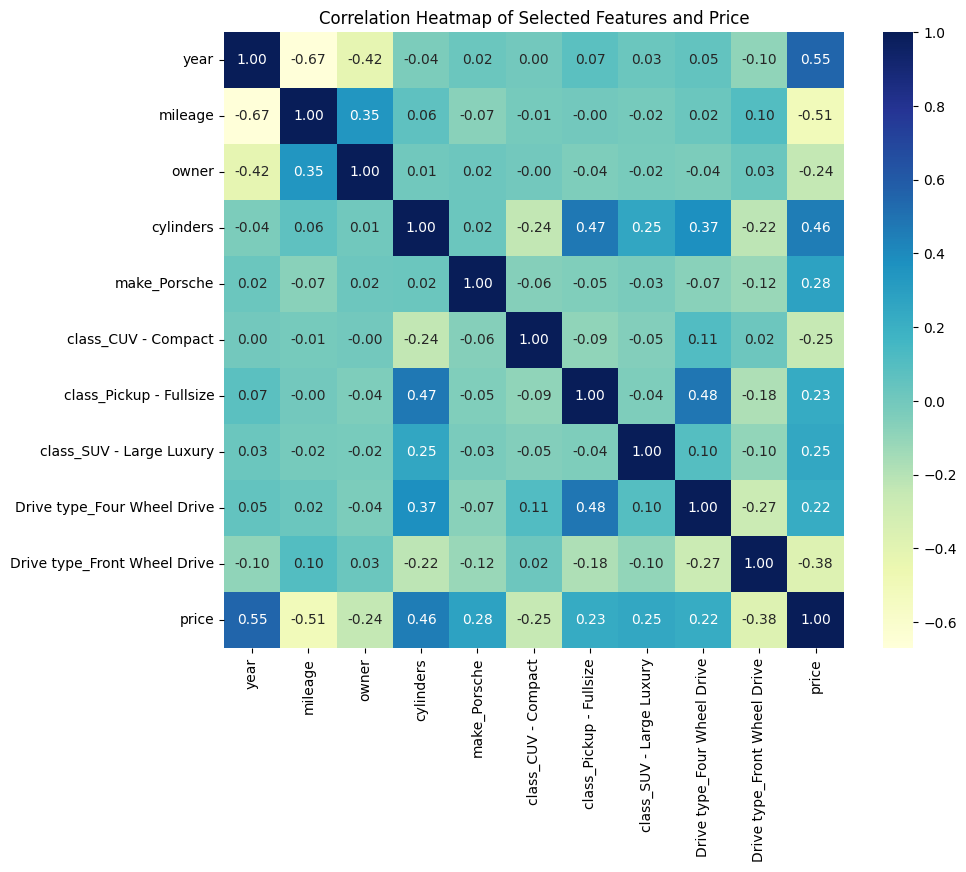

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature Importance Scores
feature_scores = selector.scores_[selected_features]
plt.figure(figsize = (12, 6))
sns.barplot(x = selected_feature_names, y = feature_scores)
plt.xticks(rotation = 45, ha='right')
plt.title("Top Selected Features by Importance Score")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Correlation Heatmap between Selected Features and Price
selected_data = x_train[selected_feature_names]
selected_data['price'] = y_train.values

plt.figure(figsize = (10, 8))
sns.heatmap(selected_data.corr(), annot = True, cmap = "YlGnBu", fmt = ".2f")
plt.title("Correlation Heatmap of Selected Features and Price")
plt.show()

In [13]:
pip install --upgrade --force-reinstall numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 6.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.1.3 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Process 2. Given 'exterior_color' 'interior_color', predict used car prices based on color using RandomForestRegressor
Optimal n_estimators: 250  
Root Mean Squared Error of model: 10597.23  
R-squared of model: 0.037491  
(1) The model accuracy is very low, indicating that these two features alone cannot accurately predict the used car price.   
(2) The feature importance of color in the random forest decision shows that interior_color_Red and interior_color_Brown are the two key features when the RandomForestRegressor model makes decisions, which is consistent with the price-based correlation findings.

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

# Feed color
x_temp = df_unique[['exterior_color', 'interior_color', 'price']]
df_encoded = pd.get_dummies(x_temp)
if 'fuel_encoded' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns = ['fuel_encoded'])
train_data, test_data = train_test_split(df_encoded, test_size = 0.5, random_state = 30)
x_train = train_data.drop(columns=['price'])
x_test = test_data.drop(columns=['price'])
y_train = train_data['price']
y_test = test_data['price']

# Learn n_estimators
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]
}

# Initialize the model with a fixed random_state
model = RandomForestRegressor(random_state = 42)

# Perform Grid Search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_search.fit(x_train, y_train)

# Get the best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']
print("Optimal n_estimators:", best_n_estimators)

# Initialize and fit the model
# best_n_estimators = 200
model = RandomForestRegressor(n_estimators = best_n_estimators, random_state = 42)
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Calculate performance for regression
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error of model: {rmse:.2f}")
print(f"R-squared of model: {r2:.6f}")

# Print feature importances
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Top 20 features

# Selected feature names
selected_feature_names = x_train.columns[indices]
print("Top 10 important features based on Random Forest:", selected_feature_names)

important_features = pd.Series(feature_importances, index = x_train.columns).sort_values(ascending = False)
important_features

Optimal n_estimators: 250
Root Mean Squared Error of model: 10597.23
R-squared of model: 0.037491
Top 10 important features based on Random Forest: Index(['interior_color_White', 'exterior_color_Pearl', 'exterior_color_Gold',
       'exterior_color_Black', 'exterior_color_Green', 'exterior_color_Brown',
       'interior_color_Tan', 'interior_color_Black', 'exterior_color_Gray',
       'exterior_color_Burgundy', 'interior_color_Cream', 'exterior_color_Tan',
       'exterior_color_White', 'exterior_color_Blue', 'exterior_color_Red',
       'exterior_color_Silver', 'interior_color_Burgundy',
       'interior_color_Gray', 'interior_color_Brown', 'interior_color_Red'],
      dtype='object')


interior_color_Red          0.173266
interior_color_Brown        0.169657
interior_color_Gray         0.085929
interior_color_Burgundy     0.075608
exterior_color_Silver       0.063121
exterior_color_Red          0.057595
exterior_color_Blue         0.041328
exterior_color_White        0.037385
exterior_color_Tan          0.033658
interior_color_Cream        0.032817
exterior_color_Burgundy     0.025158
exterior_color_Gray         0.024772
interior_color_Black        0.023452
interior_color_Tan          0.023298
exterior_color_Brown        0.021979
exterior_color_Green        0.019749
exterior_color_Black        0.017955
exterior_color_Gold         0.015052
exterior_color_Pearl        0.013629
interior_color_White        0.010168
exterior_color_Purple       0.005784
interior_color_Taupe        0.005084
exterior_color_Creme        0.004226
exterior_color_Orange       0.004001
exterior_color_Yellow       0.003398
interior_color_Champagne    0.002939
exterior_color_Teal         0.002178
e

### Process 3. Predict used car prices based on all features except color using RandomForestRegressor
Optimal n_estimators: 200
Root Mean Squared Error of model: 3427.90
R-squared of model: 0.893483   
(1) The model accuracy is high, indicating that the RandomForestRegressor model can make relatively accurate predictions when all features except color are input.    
(2) Year and cylinders are two key features as is shown in the feature importance.

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

# Feed all features excepet color
df_unique_except_color = df_unique.drop(columns = ['exterior_color', 'interior_color'])
df_encoded = pd.get_dummies(df_unique_except_color)
if 'fuel_encoded' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns = ['fuel_encoded'])
train_data, test_data = train_test_split(df_encoded, test_size = 0.2, random_state = 42)
x_train = train_data.drop(columns=['price'])
x_test = test_data.drop(columns=['price'])
y_train = train_data['price']
y_test = test_data['price']

# Learn n_estimators
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]
}

# Initialize the model with a fixed random_state
model = RandomForestRegressor(random_state = 42)

# Perform Grid Search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_search.fit(x_train, y_train)

# Get the best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']
print("Optimal n_estimators:", best_n_estimators)

# Initialize and fit the model
# best_n_estimators = 150
model = RandomForestRegressor(n_estimators = best_n_estimators, random_state = 42) # random_state = 50
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Calculate performance for regression
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error of model: {rmse:.2f}")
print(f"R-squared of model: {r2:.6f}")

# Print feature importances
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Top 20 features

# Selected feature names
selected_feature_names = x_train.columns[indices]
# important_features = pd.Series(feature_importances, index = x_train.columns).sort_values(ascending = False)

# Extract the base feature names
base_feature_names = list(set([name.split('_')[0] for name in selected_feature_names]))
print("Top 20 important base feature names:", base_feature_names)

Optimal n_estimators: 200
Root Mean Squared Error of model: 3427.90
R-squared of model: 0.893483
Top 20 important base feature names: ['Drive type', 'fuel', 'mileage', 'make', 'model', 'year', 'Bed Length', 'class', 'cylinders']


### Process 4. Predicting used car prices based on all features using RandomForestRegressor
Optimal n_estimators: 150  
Root Mean Squared Error of model: 3481.89  
R-squared of model: 0.890101  
(1) The model accuracy is high, indicating that the RandomForestRegressor model can make relatively accurate predictions when all features are input.  
(2) Year and cylinders are two key features as is shown in the feature importance.

In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

# Feed all features
df_encoded = pd.get_dummies(df_unique)
if 'fuel_encoded' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns = ['fuel_encoded'])
train_data, test_data = train_test_split(df_encoded, test_size = 0.2, random_state = 42)
x_train = train_data.drop(columns=['price'])
x_test = test_data.drop(columns=['price'])
y_train = train_data['price']
y_test = test_data['price']

# # Learn n_estimators
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]
}

# Initialize the model with a fixed random_state
model = RandomForestRegressor(random_state = 42)

# Perform Grid Search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_search.fit(x_train, y_train)

# Get the best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']
print("Optimal n_estimators:", best_n_estimators)

# Initialize and fit the model
# best_n_estimators = 200
model = RandomForestRegressor(n_estimators = best_n_estimators, random_state = 42) # random_state = 50
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Calculate performance for regression
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error of model: {rmse:.2f}")
print(f"R-squared of model: {r2:.6f}")

# Print feature importances
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Top 20 features

# Selected feature names
selected_feature_names = x_train.columns[indices]
# important_features = pd.Series(feature_importances, index = x_train.columns).sort_values(ascending = False)

# Extract the base feature names
base_feature_names = list(set([name.split('_')[0] for name in selected_feature_names]))
print("Top 20 important base feature names:", base_feature_names)

Optimal n_estimators: 150
Root Mean Squared Error of model: 3481.89
R-squared of model: 0.890101
Top 11 important base feature names: ['Drive type', 'fuel', 'mileage', 'make', 'model', 'year', 'Bed Length', 'class', 'cylinders']


### Process 5. Plot top features found by RandomForestRegressor given all features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Print feature importances
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Top 20 features

# Selected feature names and their importances
selected_feature_names = x_train.columns[indices]
selected_feature_importances = feature_importances[indices]  # Select only top 20 importances

# Create DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_feature_importances
})

# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Feature', y='Importance')
plt.xticks(rotation=45, ha='right')
plt.title("Top Selected Features by Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

selected_feature_names_by_RF = selected_feature_names

### Process 6. Compare the performance given different condition combination

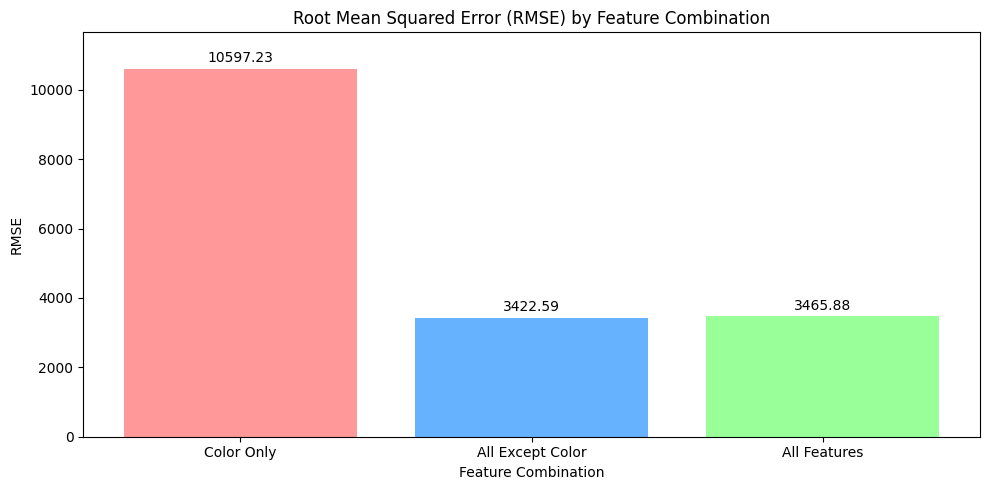

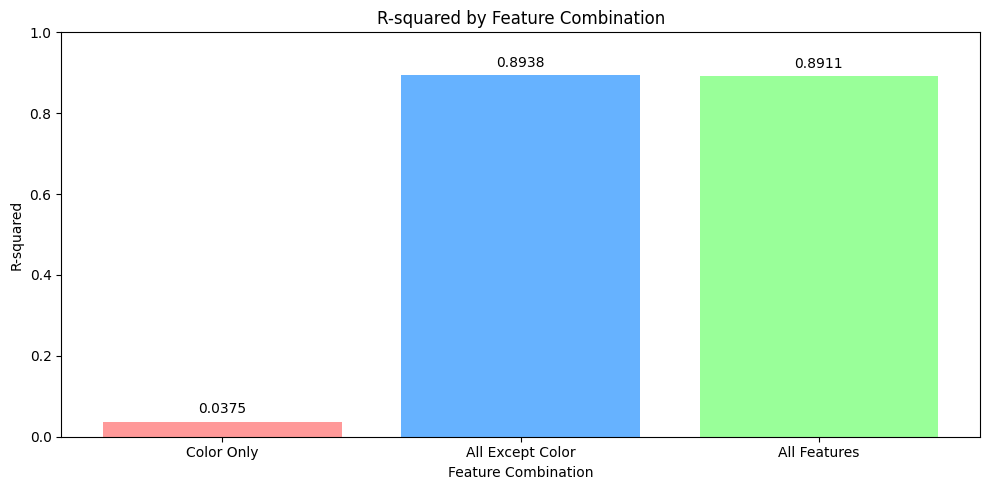

In [154]:
import matplotlib.pyplot as plt

# Data for the plots
feature_combinations = ['Color Only', 'All Except Color', 'All Features']
rmse_values = [10597.23, 3422.59, 3465.88]
r_squared_values = [0.037491, 0.893813, 0.891110]

# Plotting RMSE
plt.figure(figsize = (10, 5))
plt.bar(feature_combinations, rmse_values, color = ['#FF9999', '#66B2FF', '#99FF99'])
plt.title("Root Mean Squared Error (RMSE) by Feature Combination")
plt.xlabel("Feature Combination")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_values) * 1.1)  # Add some space above max RMSE for visibility
for i, v in enumerate(rmse_values):
    plt.text(i, v + 200, f"{v:.2f}", ha = 'center')
plt.tight_layout()
plt.show()

# Plotting R-squared
plt.figure(figsize = (10, 5))
plt.bar(feature_combinations, r_squared_values, color = ['#FF9999', '#66B2FF', '#99FF99'])
plt.title("R-squared by Feature Combination")
plt.xlabel("Feature Combination")
plt.ylabel("R-squared")
plt.ylim(0, 1)  # Since R-squared is between 0 and 1
for i, v in enumerate(r_squared_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha = 'center')
plt.tight_layout()
plt.show()


### Process 7. Compare the performance when finding top features by LinearRegression

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feed all features
df_encoded = pd.get_dummies(df_unique)
if 'fuel_encoded' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns = ['fuel_encoded'])
train_data, test_data = train_test_split(df_encoded, test_size = 0.2, random_state = 42)
x_train = train_data.drop(columns=['price'])
x_test = test_data.drop(columns=['price'])
y_train = train_data['price']
y_test = test_data['price']

# Model with SelectKBest features
X_train_kb = x_train[selected_feature_names_by_KB]
X_test_kb = test_data[selected_feature_names_by_KB]
y_test = test_data['price']

model_kb = LinearRegression()
model_kb.fit(X_train_kb, y_train)
y_pred_kb = model_kb.predict(X_test_kb)
rmse_kb = np.sqrt(mean_squared_error(y_test, y_pred_kb))
r2_kb = r2_score(y_test, y_pred_kb)

# Model with Random Forest selected features
X_train_rf = x_train[selected_feature_names_by_RF]
X_test_rf = test_data[selected_feature_names_by_RF]

model_rf = LinearRegression()
model_rf.fit(X_train_rf, y_train)
y_pred_rf = model_rf.predict(X_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print(f"Model with SelectKBest features - RMSE: {rmse_kb:.2f}, R-squared: {r2_kb:.4f}")
print(f"Model with Random Forest features - RMSE: {rmse_rf:.2f}, R-squared: {r2_rf:.4f}")


Model with SelectKBest features - RMSE: 5954.33, R-squared: 0.6786
Model with Random Forest features - RMSE: 5507.96, R-squared: 0.7250


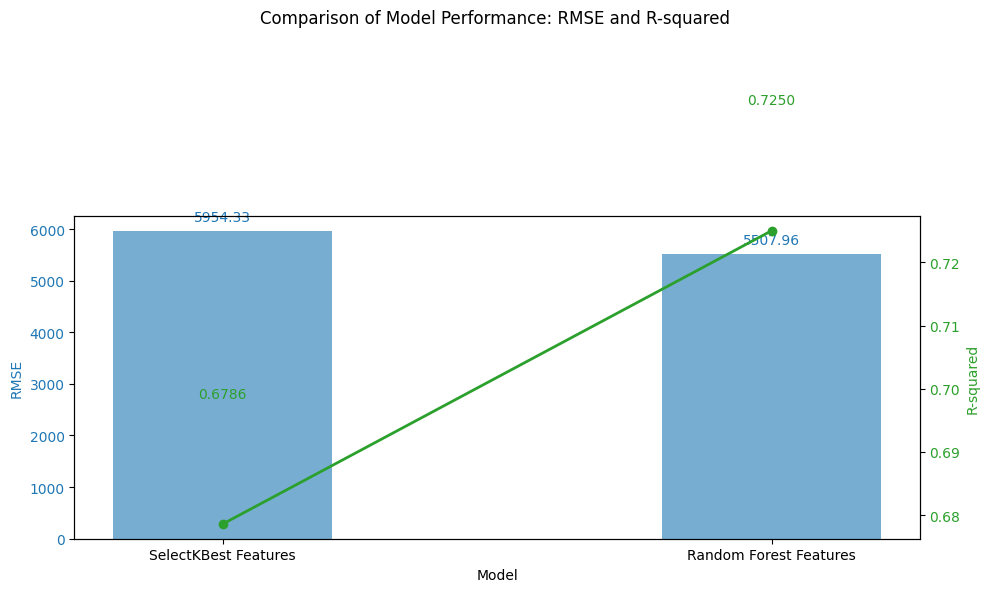

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plots
model_names = ['SelectKBest Features', 'Random Forest Features']
rmse_values = [5954.33, 5507.96]
r_squared_values = [0.6786, 0.7250]

# Create a figure and a set of subplots with dual y-axes
fig, ax1 = plt.subplots(figsize = (10, 6))

# Plot RMSE on the left y-axis
color = 'tab:blue'
ax1.set_xlabel("Model")
ax1.set_ylabel("RMSE", color = color)
ax1.bar(model_names, rmse_values, color = color, alpha = 0.6, width = 0.4, align = 'center', label = "RMSE")
ax1.tick_params(axis = 'y', labelcolor = color)
for i, v in enumerate(rmse_values):
    ax1.text(i, v + 200, f"{v:.2f}", ha ='center', color = color)

# Create a second y-axis for R-squared values
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("R-squared", color = color)
ax2.plot(model_names, r_squared_values, color = color, marker = 'o', linestyle = '-', linewidth = 2, label = "R-squared")
ax2.tick_params(axis = 'y', labelcolor = color)
for i, v in enumerate(r_squared_values):
    ax2.text(i, v + 0.02, f"{v:.4f}", ha = 'center', color = color)

fig.suptitle("Comparison of Model Performance: RMSE and R-squared")
fig.tight_layout()
plt.show()


# Q2 What attributes are associated with fuel for used cars?
## Hypothesis 1
The factory configuration of the car is like a model, and the class and fuel should be strongly related.

## Hypothesis 2
Human factors or time factors such as year, have nothing to do with changes in vehicle gas types.


In [25]:
pip install catboost

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Process 1. Given 8 features ('make', 'model', 'Miles per gallon', 'class', 'Open Recall Check', 'Drive type', 'Bed Length', 'interior_color'), use CatBoostClassifier to predict fuel type

In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Prepare the feature set
if 'Unnamed: 0' in df_unique.columns:
    df_unique = df_unique.drop(columns=['Unnamed: 0'])

x = df_unique[['make', 'model', 'Miles per gallon', 'class', 'Open Recall Check', 'Drive type', 'Bed Length', 'interior_color']]
x_encoded = pd.get_dummies(x)

# Encode the target variable after handling NaN values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_unique['fuel'])

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size = 0.2, random_state = 42)
# param_grid = {
#     'iterations': [200, 500, 800],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8, 10],
#     'random_seed': [42],
#     'verbose': [100]      
# }

# # Initialize and train the CatBoost Classifier model
# model = CatBoostClassifier()
# grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)

# # Perform the grid search
# grid_search.fit(x_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy Score:", grid_search.best_score_)

# Initialize the model with best params
# best_params = grid_search.best_params_
best_params = {
    'depth': 10,
    'iterations': 800,
    'learning_rate': 0.1,
    'random_seed': 42,
    'verbose': 100
}
final_model = CatBoostClassifier(**best_params)
final_model.fit(x_train, y_train)

# Make predictions
y_pred = final_model.predict(x_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 1.8494885	total: 217ms	remaining: 2m 53s
100:	learn: 0.4291620	total: 9.54s	remaining: 1m 6s
200:	learn: 0.3498342	total: 19.5s	remaining: 58s
300:	learn: 0.3092169	total: 29.2s	remaining: 48.4s
400:	learn: 0.2827559	total: 38.5s	remaining: 38.3s
500:	learn: 0.2604766	total: 48.1s	remaining: 28.7s
600:	learn: 0.2454114	total: 57.1s	remaining: 18.9s
700:	learn: 0.2303602	total: 1m 6s	remaining: 9.43s
799:	learn: 0.2154355	total: 1m 15s	remaining: 0us
Accuracy: 0.9133105802047782


### Process 2. Shorten top features list by analysising feature importance from CatBoostClassifier

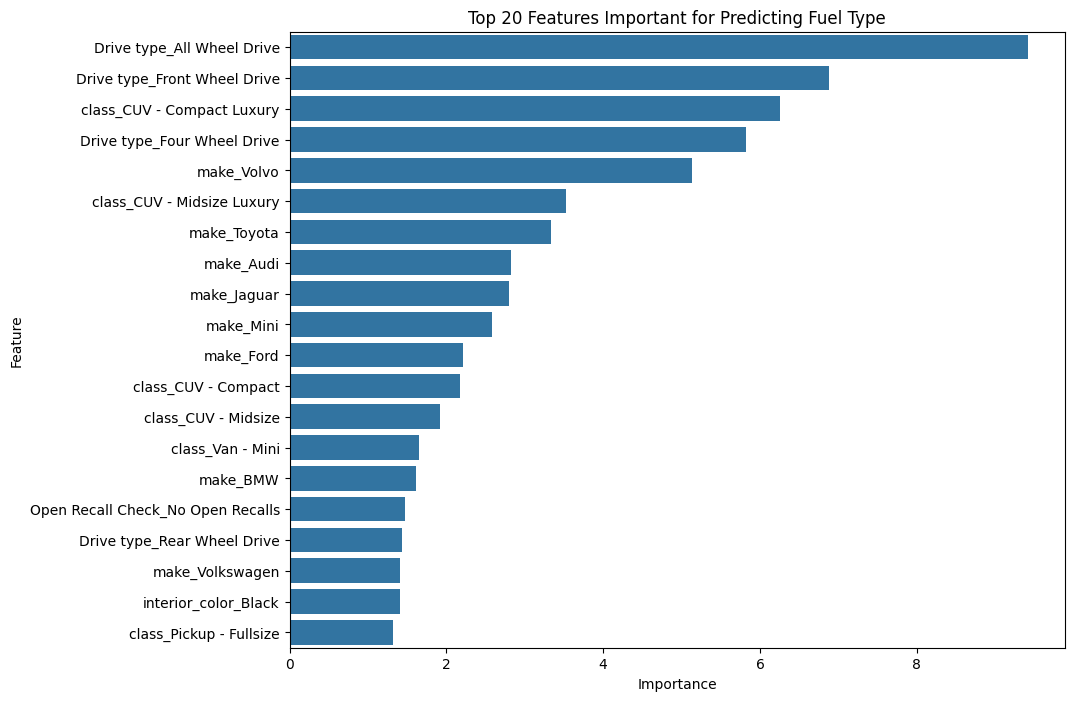

In [136]:
# Analyze Feature Importance
feature_importance = final_model.feature_importances_
features = x_encoded.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features Important for Predicting Fuel Type')
plt.show()

### Process 3. Analysis error distribution made by CatBoostClassifier model based on 8 features

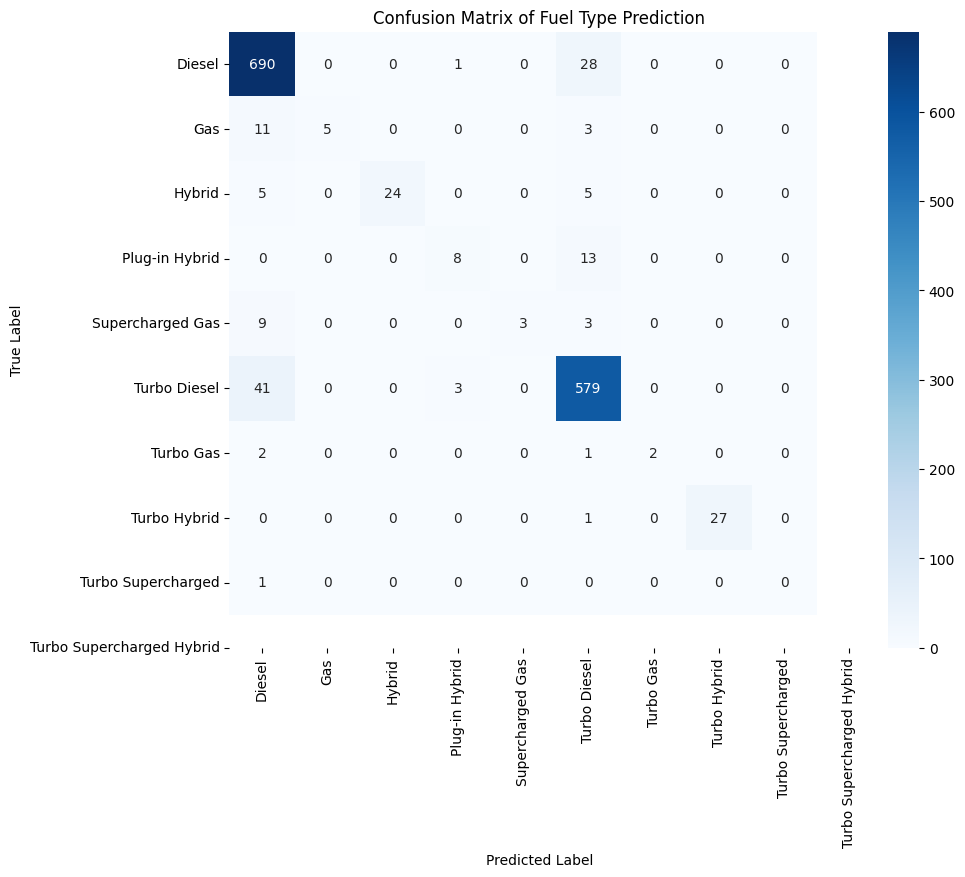

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Fuel Type Prediction")
plt.show()

### Process 4. Given 3 features ('make', 'class', 'Drive type'), use CatBoostClassifier to predict fuel type

In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Prepare the feature set
if 'Unnamed: 0' in df_unique.columns:
    df_unique = df_unique.drop(columns=['Unnamed: 0'])

x = df_unique[['make', 'class', 'Drive type']]
x_encoded = pd.get_dummies(x)

# Encode the target variable after handling NaN values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_unique['fuel'])

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size = 0.2, random_state = 42)
# param_grid = {
#     'iterations': [200, 500, 800],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8, 10],
#     'random_seed': [42],
#     'verbose': [100]      
# }

# # Initialize and train the CatBoost Classifier model
# model = CatBoostClassifier()
# grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)

# # Perform the grid search
# grid_search.fit(x_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy Score:", grid_search.best_score_)

# # Initialize the model with best params
# best_params = grid_search.best_params_
best_params = {
    'depth': 8,
    'iterations': 500,
    'learning_rate': 0.05,
    'random_seed': 42,
    'verbose': 100
}
final_model = CatBoostClassifier(**best_params)
final_model.fit(x_train, y_train)

# Make predictions
y_pred = final_model.predict(x_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

0:	learn: 2.0193010	total: 18.3ms	remaining: 9.13s
100:	learn: 0.5524451	total: 343ms	remaining: 1.36s
200:	learn: 0.4667422	total: 649ms	remaining: 965ms
300:	learn: 0.4289900	total: 968ms	remaining: 640ms
400:	learn: 0.4103201	total: 1.28s	remaining: 315ms
499:	learn: 0.3986381	total: 1.57s	remaining: 0us
Accuracy: 0.825938566552901


### Process 5. Analysis error distribution made by CatBoostClassifier model based on 3 features

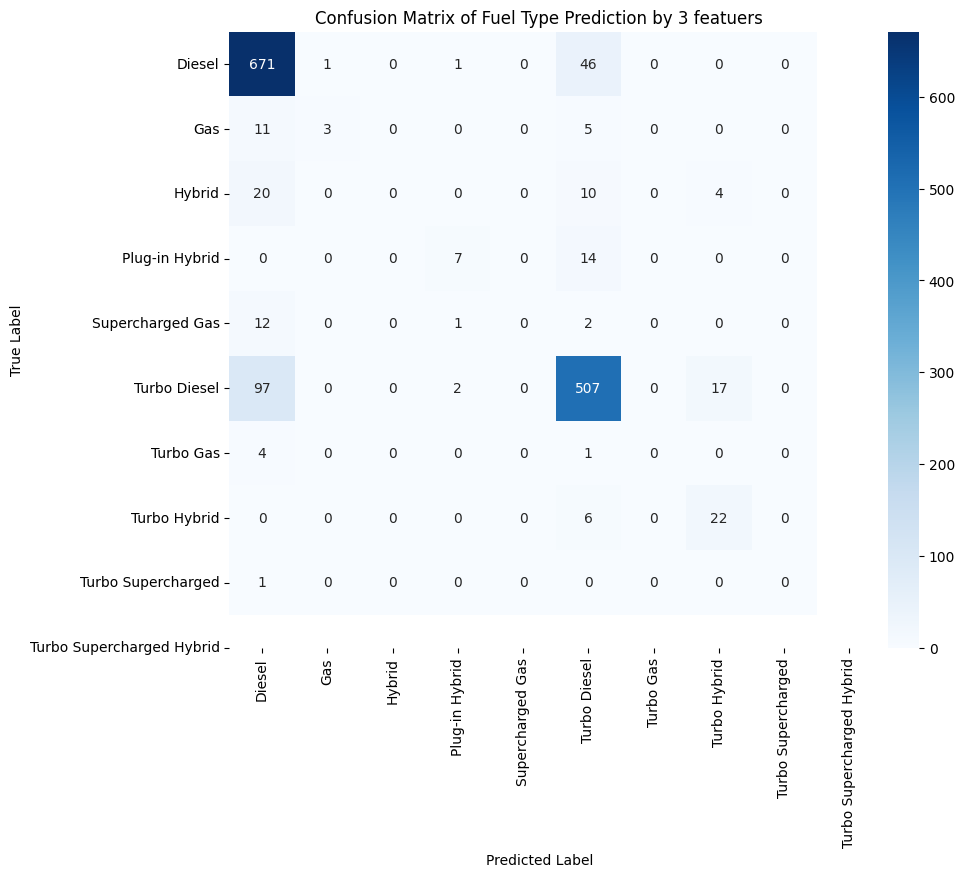

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Fuel Type Prediction by 3 featuers")
plt.show()

### Process 6. Compare the accuracy of model made on 8 features and 3 features

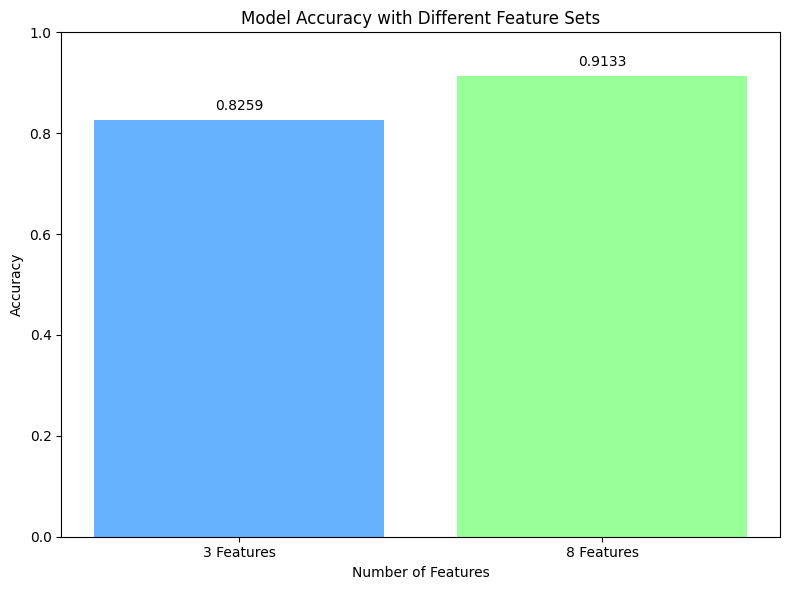

In [146]:
import matplotlib.pyplot as plt

# Data for the plot
feature_counts = ['3 Features', '8 Features']
accuracies = [0.8259, 0.9133]

# Plotting the accuracies
plt.figure(figsize = (8, 6))
plt.bar(feature_counts, accuracies, color = ['#66B2FF', '#99FF99'])
plt.ylim(0, 1)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Model Accuracy with Different Feature Sets")

# Adding the accuracy values on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha = 'center')

plt.tight_layout()
plt.show()